<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

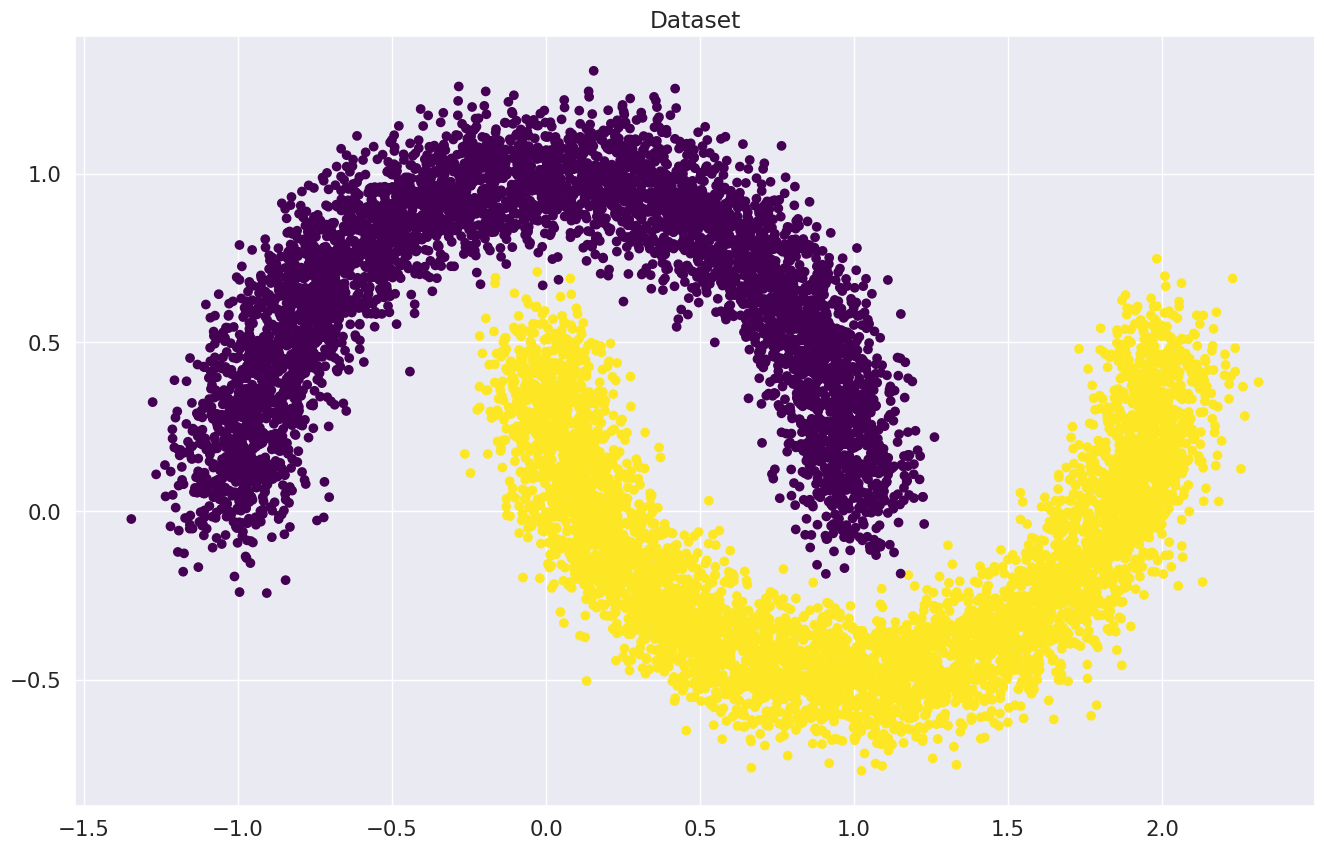

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.from_numpy(X_train).type(torch.float32)
y_train_t =  torch.from_numpy(y_train).type(torch.float32)
X_val_t =  torch.from_numpy(X_val).type(torch.float32)
y_val_t =  torch.from_numpy(y_val).type(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((out_features)), requires_grad=True)

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x.add(self.bias_term)
        return x.flatten()

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

Поскольку у нас подаются на вход всего две фичи, а нейронная сеть представляет собой линейную регрессию, то всего наша матрица весов одного-единственного слоя содержит 2 весовых коэффициента. Ну и плюс bias, итого получаем 3 обучаемых параметра. Можно посмотреть на них с помощью следующей команды:

In [ ]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-0.9055],
         [-1.8142]], requires_grad=True),
 Parameter containing:
 tensor([-1.1679], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = outp.sigmoid()
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6015625
Iteration: 100
Batch accuracy: 0.859375
Iteration: 200
Batch accuracy: 0.8515625
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375

Iteration: 401.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** Хотя алгоритм и завершился, но на самом деле он не сошелся, а лишь уперся в ограничения, которые были заданы ему заранее. Было бы странно, если бы линейная регрессия сошлась на линейно неразделимой выборке (визуализацию этого мы увидим чуть ниже)

### Визуализируем результаты

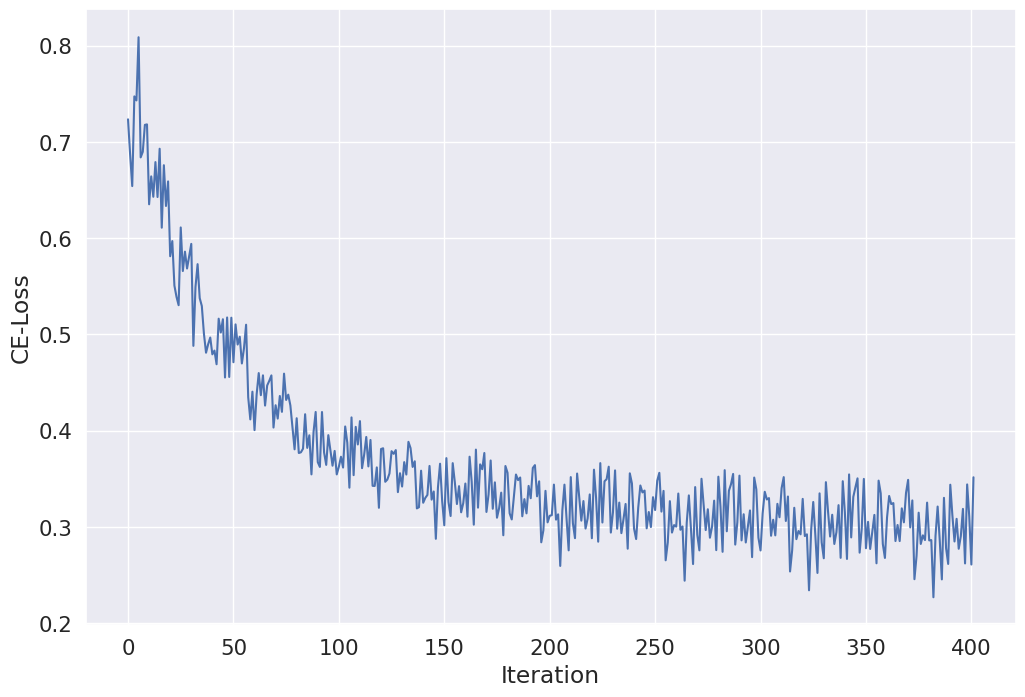

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("CE-Loss")
plt.show()

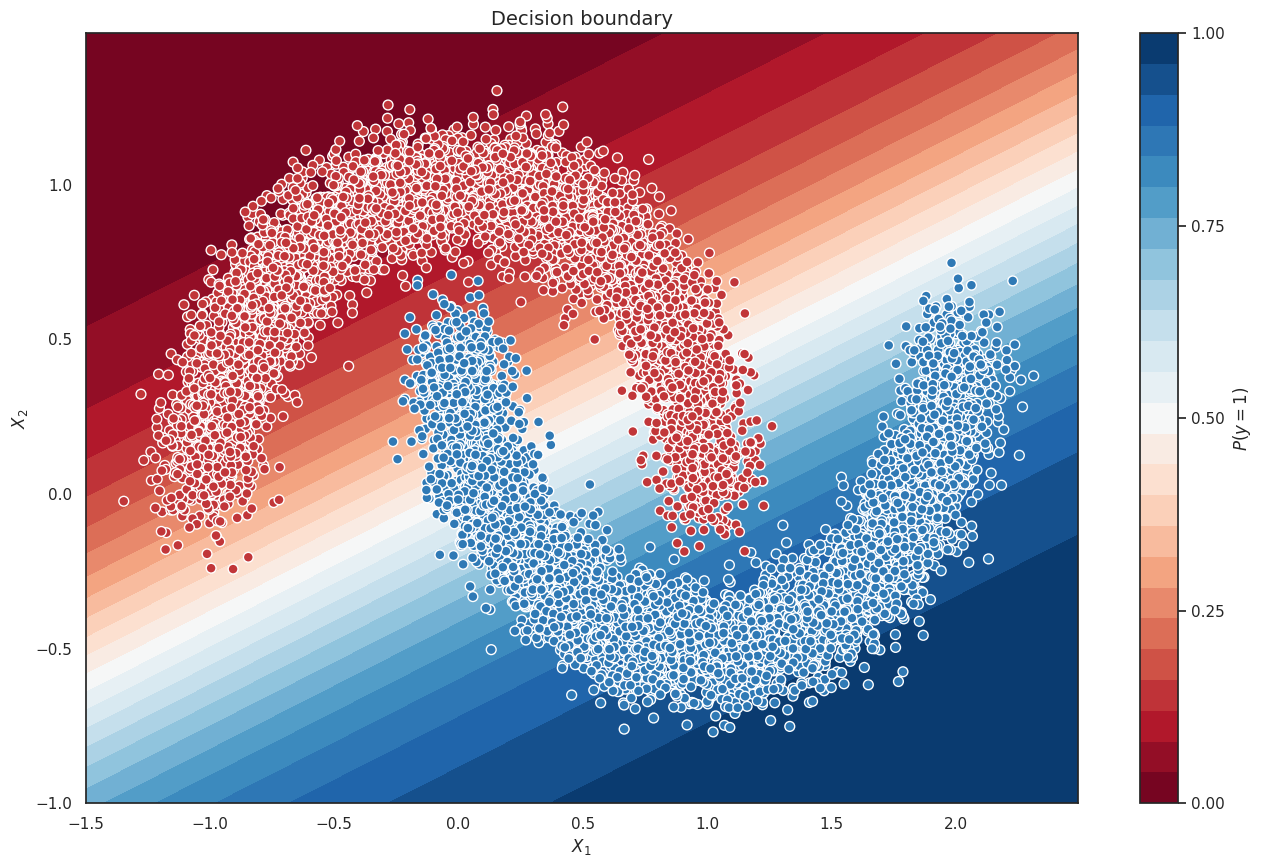

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch).sigmoid() > 0.5
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

pred = predict(val_dataloader, linear_regression)
batch_acc = (pred.flatten() == y_val).sum() / y_val.shape[0]
print(batch_acc)


0.872


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** получившееся `accuracy = 0.872`.
Однако оно было достигнуто не засчет выявления каких-то закономерностей, а засчет того, что наша линейная регрессия просто нашла самую массивную область с синими точками, и вне зависимости от количества красных точек просто стала классифицировать все точки в ней как синие. Полученное число является просто грубым подгоном, достигнутым благодаря примитивности линейной регрессии

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

device = "cuda" if torch.cuda.is_available() else "cpu"

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [ ]:
for x, y in train_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y.dtype)
  break

torch.Size([128, 1, 28, 28])
torch.float32
torch.int64


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU
features = 784  # number of flattened array
classes = 10    # number of classes

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    # don't need softmax here!
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9917201399803162
Loader: valid. Accuracy: 0.9766626954078674
Epoch: 2
Loader: train. Accuracy: 0.9940071105957031
Loader: valid. Accuracy: 0.9727564454078674
Epoch: 3
Loader: train. Accuracy: 0.9948251247406006
Loader: valid. Accuracy: 0.9762620329856873
Epoch: 4
Loader: train. Accuracy: 0.9954928159713745
Loader: valid. Accuracy: 0.9731570482254028
Epoch: 5
Loader: train. Accuracy: 0.9946081042289734
Loader: valid. Accuracy: 0.9721554517745972


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  print("Testing new activation function: ", activation)
  features = 784  # number of flattened array
  classes = 10    # number of classes

  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, classes),
      # don't need softmax here!
  )
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  max_epochs = 5
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
              if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
              else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
              preds = outp.argmax(-1)
              correct = (preds == y_batch).sum()
              all =  batch_size
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy


In [ ]:
elu_accuracy = test_activation_function(nn.ELU)
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
tanh_accuracy = test_activation_function(nn.Tanh)
sigmoid_accuracy = test_activation_function(nn.Sigmoid)

Testing new activation function:  <class 'torch.nn.modules.activation.ELU'>
Epoch: 1
Loader: train. Accuracy: 0.8796741452991453
Loader: valid. Accuracy: 0.9324919871794872
Epoch: 2
Loader: train. Accuracy: 0.94140625
Loader: valid. Accuracy: 0.9502203525641025
Epoch: 3
Loader: train. Accuracy: 0.9596521100427351
Loader: valid. Accuracy: 0.9618389423076923
Epoch: 4
Loader: train. Accuracy: 0.9685496794871795
Loader: valid. Accuracy: 0.9661458333333334
Epoch: 5
Loader: train. Accuracy: 0.9745259081196581
Loader: valid. Accuracy: 0.96875
Testing new activation function:  <class '__main__.Identical'>
Epoch: 1
Loader: train. Accuracy: 0.863014155982906
Loader: valid. Accuracy: 0.8873197115384616
Epoch: 2
Loader: train. Accuracy: 0.8960503472222222
Loader: valid. Accuracy: 0.8946314102564102
Epoch: 3
Loader: train. Accuracy: 0.9005408653846154
Loader: valid. Accuracy: 0.8964342948717948
Epoch: 4
Loader: train. Accuracy: 0.9026943108974359
Loader: valid. Accuracy: 0.8983373397435898
Epoch: 5

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

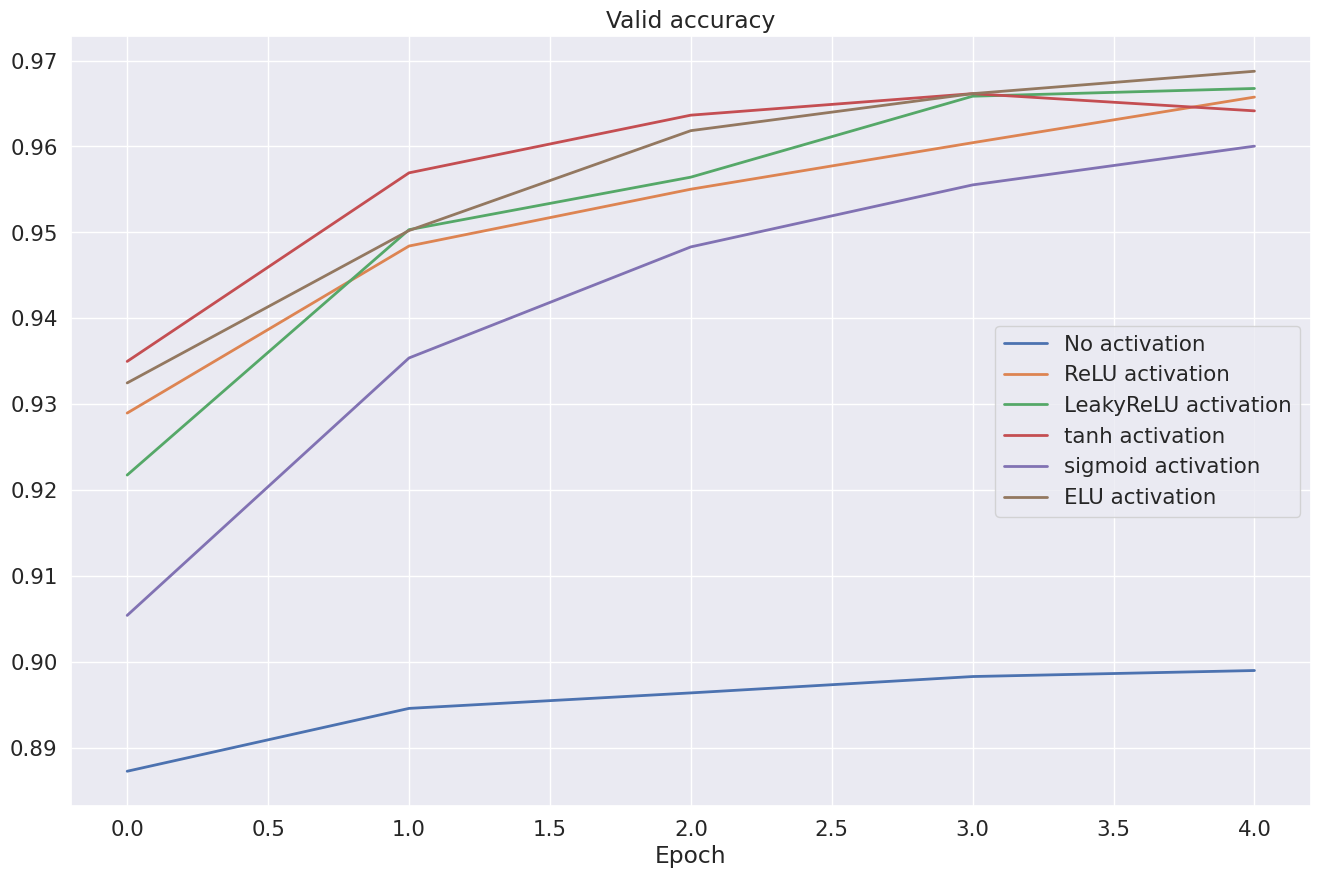

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

x_size = len(relu_accuracy['valid'])

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(x_size), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['valid'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['valid'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU, `accuracy=0.968249`

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-01 15:12:29--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   165KB/s    in 0.3s    

2023-11-01 15:12:30 (165 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



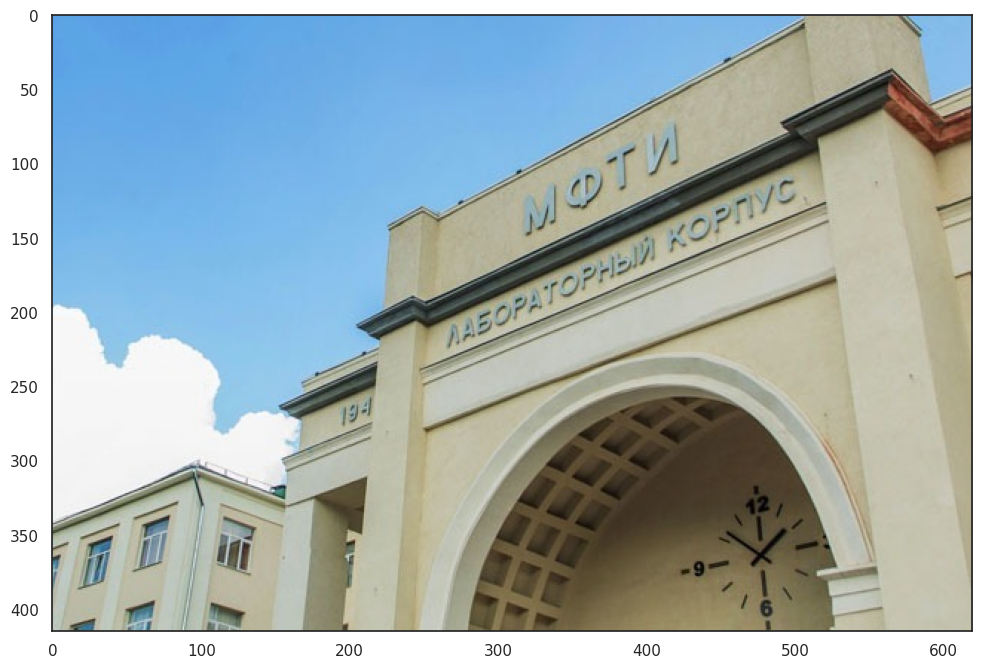

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
  [0, -1, 0],
  [-1, 5, -1],
  [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

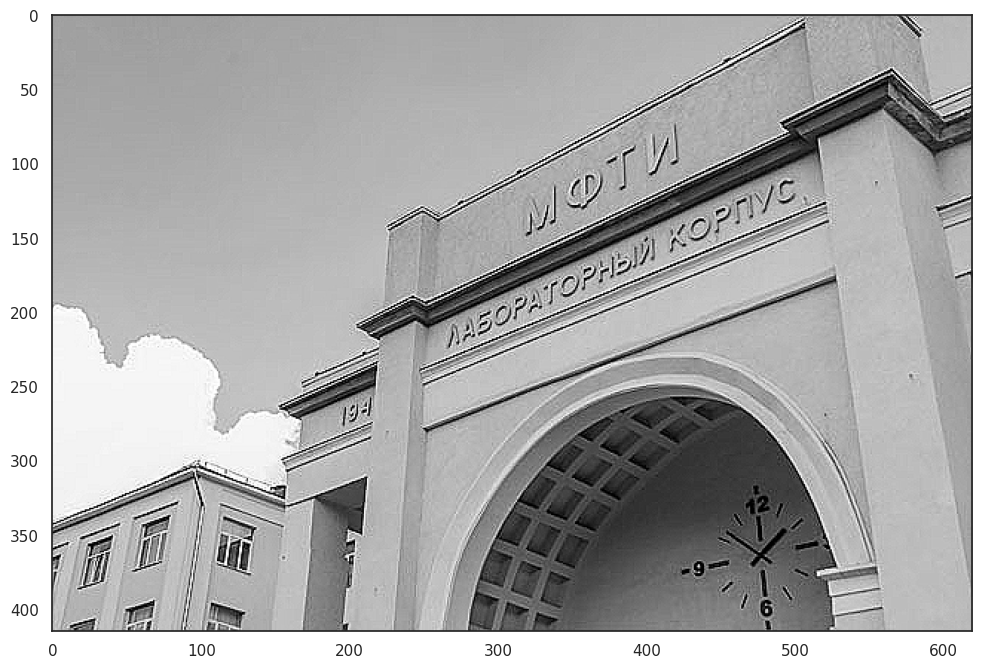

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

A - 3

Б - 5

В - 4

Г - 6

Д - 2

Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  batch_size
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)



Epoch: 1
Loader: train. Accuracy: 0.9708366720085471
Loader: valid. Accuracy: 0.9772636217948718
Epoch: 2
Loader: train. Accuracy: 0.9793502938034188
Loader: valid. Accuracy: 0.9827724358974359
Epoch: 3
Loader: train. Accuracy: 0.9836404914529915
Loader: valid. Accuracy: 0.9831730769230769
Epoch: 4
Loader: train. Accuracy: 0.9865618322649573
Loader: valid. Accuracy: 0.9833733974358975
Epoch: 5
Loader: train. Accuracy: 0.9884481837606838
Loader: valid. Accuracy: 0.9852764423076923


In [ ]:
lenet_accuracy = accuracy

Сравним с предыдущем пунктом

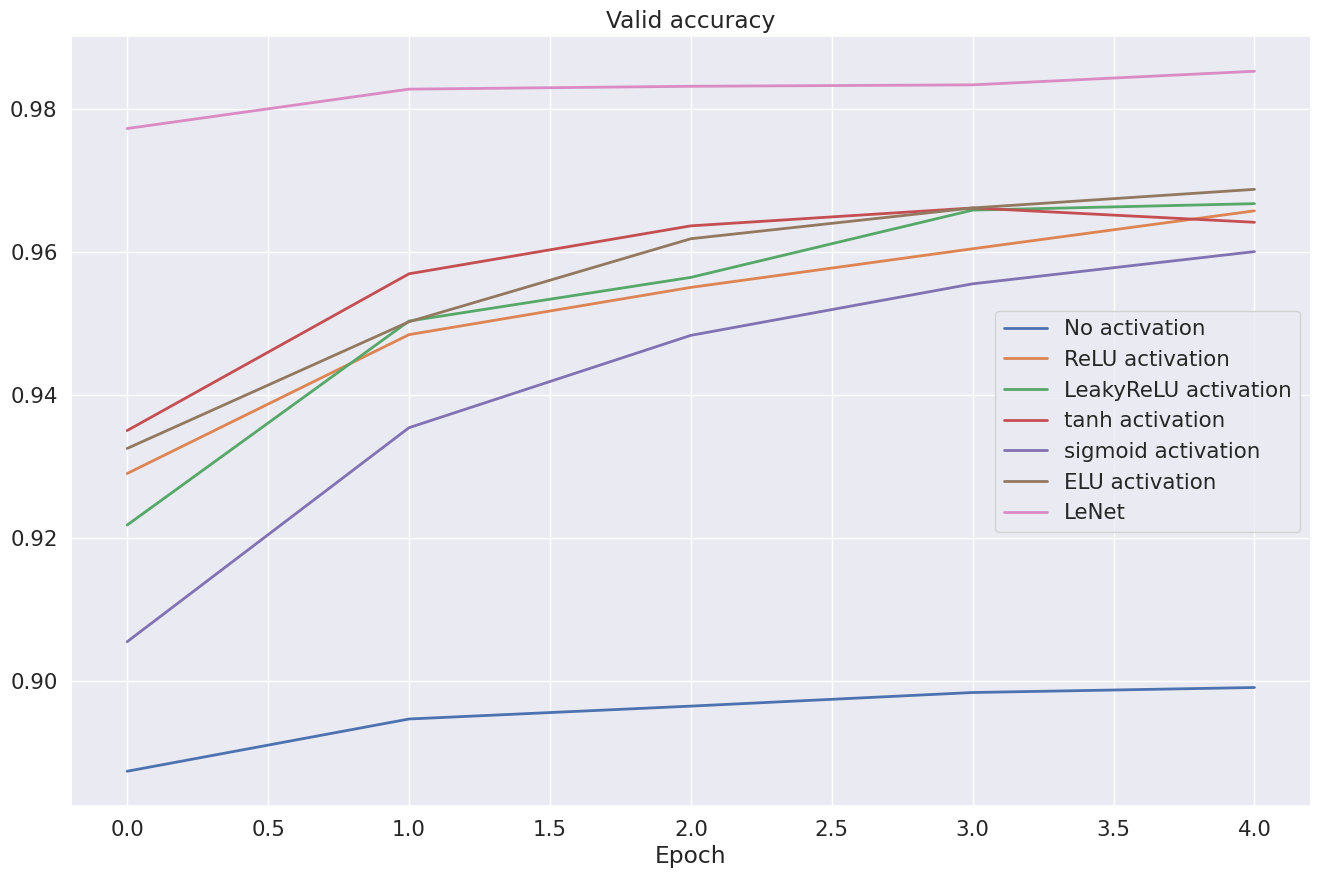

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(x_size), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['valid'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['valid'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(x_size), lenet_accuracy['valid'], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** `epochs = 7 -> accuracy = 0.985`

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

device = "cuda" if torch.cuda.is_available() else "cpu"

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

activation = nn.ELU
features = 784  # number of flattened array
classes = 10    # number of classes

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    # don't need softmax here!
)
model.to(device)
print(device)
summary(model, (features,), batch_size=batch_size)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9536425471305847
Loader: valid. Accuracy: 0.9564303159713745
Epoch: 2
Loader: train. Accuracy: 0.965928852558136
Loader: valid. Accuracy: 0.9640424847602844
Epoch: 3
Loader: train. Accuracy: 0.9731237292289734
Loader: valid. Accuracy: 0.9659455418586731
Epoch: 4
Loader: train. Accuracy: 0.9785156846046448
Loader: valid. Accuracy: 0.966646671295166
Epoch: 5
Loader: train. Accuracy: 0.9818877577781677
Loader: valid. Accuracy: 0.96875
Epoch: 6
Loader: train. Accuracy: 0.9840579032897949
Loader: valid. Accuracy: 0.9715545177459717
Epoch: 7
Loader: train. Accuracy: 0.9859442114830017
Loader: valid. Accuracy: 0.9703525900840759
Epoch: 8
Loader: train. Accuracy: 0.9868456721305847
Loader: valid. Accuracy: 0.9686498641967773
Epoch: 9
Loader: train. Accuracy: 0.9878472685813904
Loader: valid. Accuracy: 0.9677484035491943
Epoch: 10
Loader: train. Accuracy: 0.9894665479660034
Loader: valid. Accuracy: 0.9751602411270142
